In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model_1 as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [2]:
# print gpu
torch.cuda.set_device(5)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 5
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = "cpu"
print(device)

cuda:5


In [ ]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [4]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.ToTensor(),
                                               dt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])                                           
                                           ]))
# TODO: change the normalization parameters

In [5]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=50,
                        shuffle=True, num_workers=0)

In [ ]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [6]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [17]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -(ssim(output, targetf)-1)
        
        p = 0.75
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [8]:
for epoch in range(1, 10 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 1.131569266319275 lossSSIM: 1.0014219284057617
===> Epoch[1](0/16220): Loss: 1.0990
lossMSE: 0.9827163815498352 lossSSIM: 0.9804830551147461
===> Epoch[1](50/16220): Loss: 0.9822
lossMSE: 0.8950549960136414 lossSSIM: 0.8606074452400208
===> Epoch[1](100/16220): Loss: 0.8864
lossMSE: 0.7851565480232239 lossSSIM: 0.7642279863357544
===> Epoch[1](150/16220): Loss: 0.7799
lossMSE: 0.7191230058670044 lossSSIM: 0.6907466650009155
===> Epoch[1](200/16220): Loss: 0.7120
lossMSE: 0.6125665903091431 lossSSIM: 0.6322448253631592
===> Epoch[1](250/16220): Loss: 0.6175
lossMSE: 0.5245255827903748 lossSSIM: 0.5995553731918335
===> Epoch[1](300/16220): Loss: 0.5433
lossMSE: 0.49591919779777527 lossSSIM: 0.5268158316612244
===> Epoch[1](350/16220): Loss: 0.5036
lossMSE: 0.4281225800514221 lossSSIM: 0.5338224172592163
===> Epoch[1](400/16220): Loss: 0.4545
lossMSE: 0.3797565698623657 lossSSIM: 0.5222181677818298
===> Epoch[1](450/16220): Loss: 0.4154
lossMSE: 0.33570441603660583 lossSSIM: 0.48

KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 50
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


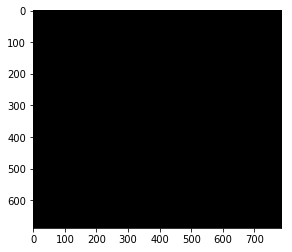

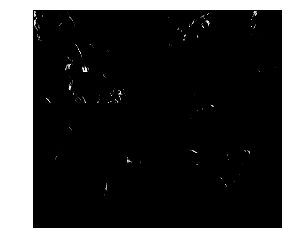

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


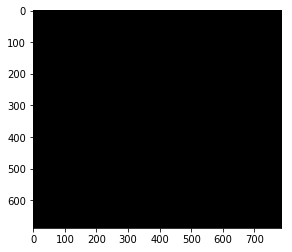

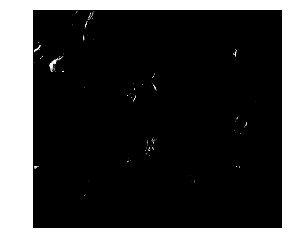

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


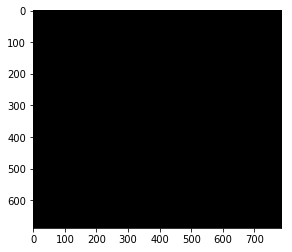

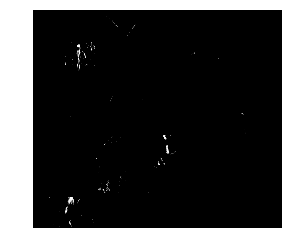

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


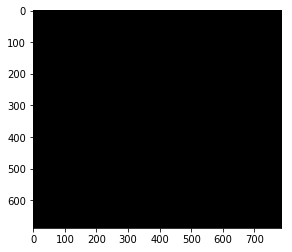

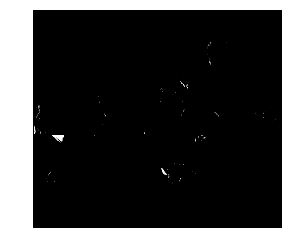

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


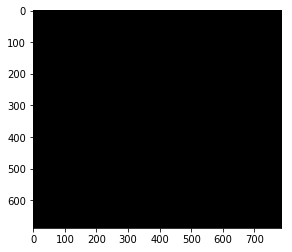

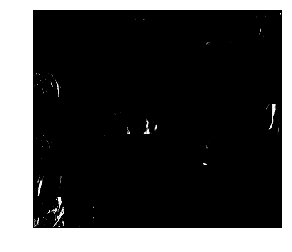

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


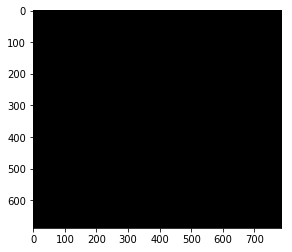

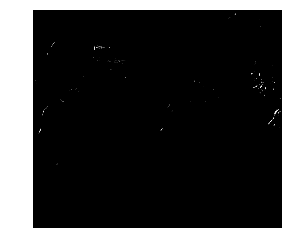

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


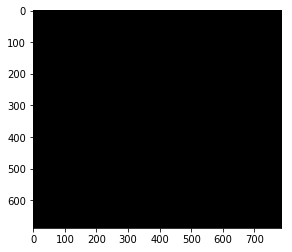

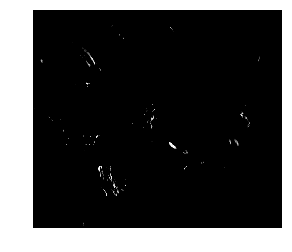

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


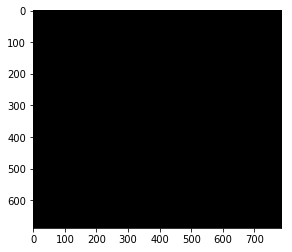

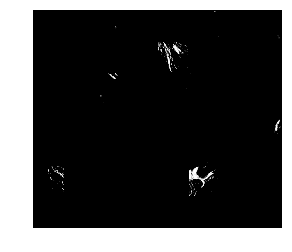

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


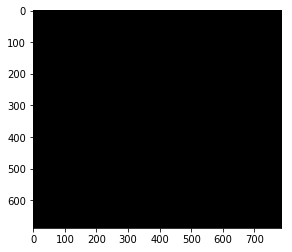

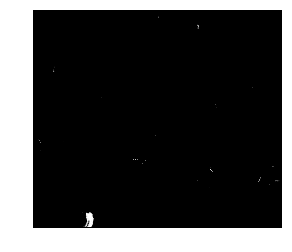

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


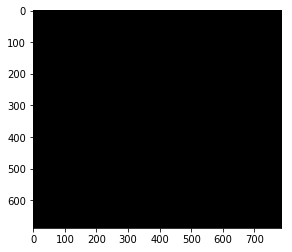

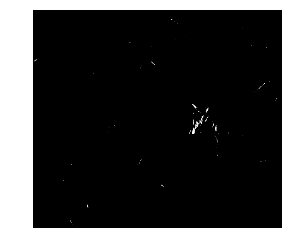

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


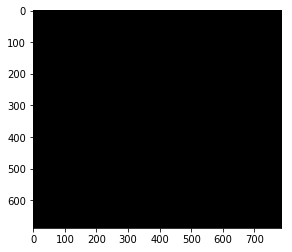

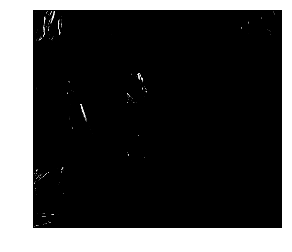

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


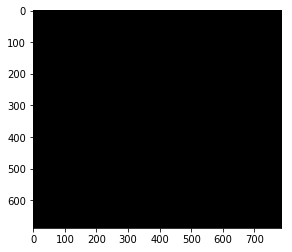

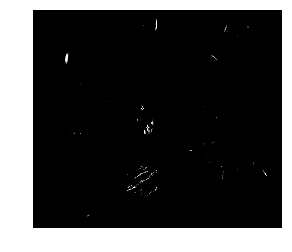

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


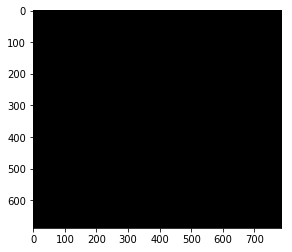

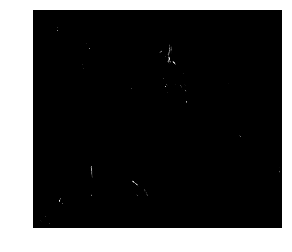

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


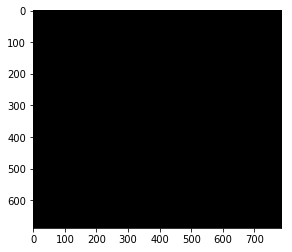

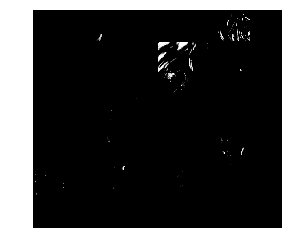

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


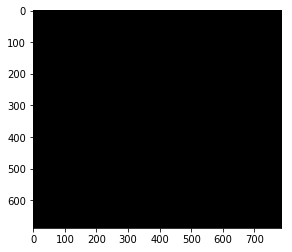

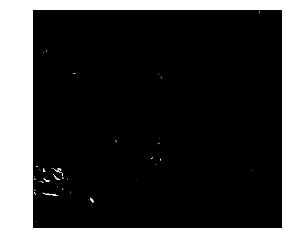

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


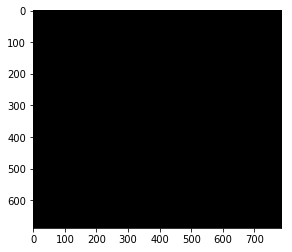

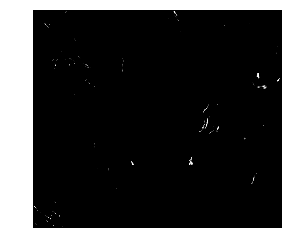

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


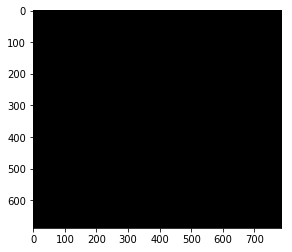

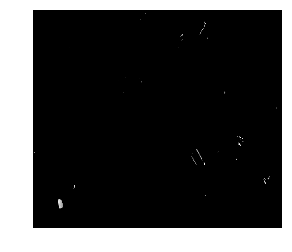

===> Avg. PSNR: nan dB


In [21]:
test()

In [ ]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

In [11]:
for epoch in range(1, 10 + 1):
    train(epoch)

lossMSE: 0.013164062052965164 lossSSIM: 0.15126419067382812
===> Epoch[1](0/16220): Loss: 0.0477
lossMSE: 0.03632668778300285 lossSSIM: 0.19392359256744385
===> Epoch[1](50/16220): Loss: 0.0757
lossMSE: 0.0299930851906538 lossSSIM: 0.19022107124328613
===> Epoch[1](100/16220): Loss: 0.0701
lossMSE: 0.03723451867699623 lossSSIM: 0.17591261863708496
===> Epoch[1](150/16220): Loss: 0.0719
lossMSE: 0.03993117809295654 lossSSIM: 0.21352040767669678
===> Epoch[1](200/16220): Loss: 0.0833
lossMSE: 0.027416275814175606 lossSSIM: 0.18140769004821777
===> Epoch[1](250/16220): Loss: 0.0659
lossMSE: 0.026887165382504463 lossSSIM: 0.1641799807548523
===> Epoch[1](300/16220): Loss: 0.0612
lossMSE: 0.015771247446537018 lossSSIM: 0.1465548276901245
===> Epoch[1](350/16220): Loss: 0.0485
lossMSE: 0.02542261965572834 lossSSIM: 0.15860235691070557
===> Epoch[1](400/16220): Loss: 0.0587
lossMSE: 0.0231075007468462 lossSSIM: 0.16780656576156616
===> Epoch[1](450/16220): Loss: 0.0593
lossMSE: 0.021218741312

lossMSE: 0.043892838060855865 lossSSIM: 0.2428112030029297
===> Epoch[1](4150/16220): Loss: 0.0936
lossMSE: 0.015995392575860023 lossSSIM: 0.13597500324249268
===> Epoch[1](4200/16220): Loss: 0.0460
lossMSE: 0.028916992247104645 lossSSIM: 0.19632452726364136
===> Epoch[1](4250/16220): Loss: 0.0708
lossMSE: 0.03492452949285507 lossSSIM: 0.15700310468673706
===> Epoch[1](4300/16220): Loss: 0.0654
lossMSE: 0.03648466616868973 lossSSIM: 0.17949837446212769
===> Epoch[1](4350/16220): Loss: 0.0722
lossMSE: 0.020400065928697586 lossSSIM: 0.16561323404312134
===> Epoch[1](4400/16220): Loss: 0.0567
lossMSE: 0.023731505498290062 lossSSIM: 0.17663753032684326
===> Epoch[1](4450/16220): Loss: 0.0620
lossMSE: 0.019932996481657028 lossSSIM: 0.1462826132774353
===> Epoch[1](4500/16220): Loss: 0.0515
lossMSE: 0.02671414241194725 lossSSIM: 0.1814647912979126
===> Epoch[1](4550/16220): Loss: 0.0654
lossMSE: 0.03417167067527771 lossSSIM: 0.18152600526809692
===> Epoch[1](4600/16220): Loss: 0.0710
lossMSE

KeyboardInterrupt: 

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
for epoch in range(1, 10 + 1):
    train(epoch)

lossMSE: 0.028376976028084755 lossSSIM: 0.17974764108657837
===> Epoch[1](0/16220): Loss: 0.0662
lossMSE: 0.04249567165970802 lossSSIM: 0.2020389437675476
===> Epoch[1](50/16220): Loss: 0.0824
lossMSE: 0.01458021067082882 lossSSIM: 0.16687607765197754
===> Epoch[1](100/16220): Loss: 0.0527
lossMSE: 0.018620477989315987 lossSSIM: 0.16681671142578125
===> Epoch[1](150/16220): Loss: 0.0557
lossMSE: 0.023984011262655258 lossSSIM: 0.19729751348495483
===> Epoch[1](200/16220): Loss: 0.0673
lossMSE: 0.023939099162817 lossSSIM: 0.17049026489257812
===> Epoch[1](250/16220): Loss: 0.0606
lossMSE: 0.028266457840800285 lossSSIM: 0.17096996307373047
===> Epoch[1](300/16220): Loss: 0.0639
lossMSE: 0.022007593885064125 lossSSIM: 0.1767103672027588
===> Epoch[1](350/16220): Loss: 0.0607
lossMSE: 0.03634433448314667 lossSSIM: 0.17913293838500977
===> Epoch[1](400/16220): Loss: 0.0720
lossMSE: 0.02140934206545353 lossSSIM: 0.16429734230041504
===> Epoch[1](450/16220): Loss: 0.0571
lossMSE: 0.02552110515

lossMSE: 0.01640256866812706 lossSSIM: 0.15138596296310425
===> Epoch[1](4150/16220): Loss: 0.0501
lossMSE: 0.030862808227539062 lossSSIM: 0.17778122425079346
===> Epoch[1](4200/16220): Loss: 0.0676
lossMSE: 0.038860395550727844 lossSSIM: 0.2067849040031433
===> Epoch[1](4250/16220): Loss: 0.0808
lossMSE: 0.03093629702925682 lossSSIM: 0.20025873184204102
===> Epoch[1](4300/16220): Loss: 0.0733
lossMSE: 0.03111361898481846 lossSSIM: 0.16861790418624878
===> Epoch[1](4350/16220): Loss: 0.0655
lossMSE: 0.014617158100008965 lossSSIM: 0.15205830335617065
===> Epoch[1](4400/16220): Loss: 0.0490
lossMSE: 0.03130542114377022 lossSSIM: 0.1602070927619934
===> Epoch[1](4450/16220): Loss: 0.0635
lossMSE: 0.02339893765747547 lossSSIM: 0.16873377561569214
===> Epoch[1](4500/16220): Loss: 0.0597
lossMSE: 0.02558600902557373 lossSSIM: 0.15641814470291138
===> Epoch[1](4550/16220): Loss: 0.0583
lossMSE: 0.024315552785992622 lossSSIM: 0.1685909628868103
===> Epoch[1](4600/16220): Loss: 0.0604
lossMSE: 

lossMSE: 0.027269426733255386 lossSSIM: 0.16228938102722168
===> Epoch[1](8300/16220): Loss: 0.0610
lossMSE: 0.035463251173496246 lossSSIM: 0.17934823036193848
===> Epoch[1](8350/16220): Loss: 0.0714
lossMSE: 0.03577440232038498 lossSSIM: 0.19246578216552734
===> Epoch[1](8400/16220): Loss: 0.0749
lossMSE: 0.012807891704142094 lossSSIM: 0.1288614273071289
===> Epoch[1](8450/16220): Loss: 0.0418
lossMSE: 0.01702897809445858 lossSSIM: 0.15100085735321045
===> Epoch[1](8500/16220): Loss: 0.0505
lossMSE: 0.02018984965980053 lossSSIM: 0.18469274044036865
===> Epoch[1](8550/16220): Loss: 0.0613
lossMSE: 0.03718738257884979 lossSSIM: 0.1889019012451172
===> Epoch[1](8600/16220): Loss: 0.0751
lossMSE: 0.05380532890558243 lossSSIM: 0.21669930219650269
===> Epoch[1](8650/16220): Loss: 0.0945
lossMSE: 0.03362657502293587 lossSSIM: 0.14243537187576294
===> Epoch[1](8700/16220): Loss: 0.0608
lossMSE: 0.03142063692212105 lossSSIM: 0.2057526707649231
===> Epoch[1](8750/16220): Loss: 0.0750
lossMSE: 0

lossMSE: 0.011545520275831223 lossSSIM: 0.13017666339874268
===> Epoch[1](12450/16220): Loss: 0.0412
lossMSE: 0.030157016590237617 lossSSIM: 0.1949567198753357
===> Epoch[1](12500/16220): Loss: 0.0714
lossMSE: 0.03902977705001831 lossSSIM: 0.1848103404045105
===> Epoch[1](12550/16220): Loss: 0.0755
lossMSE: 0.033319421112537384 lossSSIM: 0.16734689474105835
===> Epoch[1](12600/16220): Loss: 0.0668
lossMSE: 0.01680454984307289 lossSSIM: 0.15986019372940063
===> Epoch[1](12650/16220): Loss: 0.0526
lossMSE: 0.019407790154218674 lossSSIM: 0.18000388145446777
===> Epoch[1](12700/16220): Loss: 0.0596
lossMSE: 0.03640503063797951 lossSSIM: 0.19842112064361572
===> Epoch[1](12750/16220): Loss: 0.0769
lossMSE: 0.020990341901779175 lossSSIM: 0.17213189601898193
===> Epoch[1](12800/16220): Loss: 0.0588
lossMSE: 0.03661490976810455 lossSSIM: 0.1838255524635315
===> Epoch[1](12850/16220): Loss: 0.0734
lossMSE: 0.023177914321422577 lossSSIM: 0.17021960020065308
===> Epoch[1](12900/16220): Loss: 0.05

lossMSE: 0.019717661663889885 lossSSIM: 0.17336446046829224
===> Epoch[2](300/16220): Loss: 0.0581
lossMSE: 0.010401701554656029 lossSSIM: 0.13374477624893188
===> Epoch[2](350/16220): Loss: 0.0412
lossMSE: 0.010097196325659752 lossSSIM: 0.11535018682479858
===> Epoch[2](400/16220): Loss: 0.0364
lossMSE: 0.014131253585219383 lossSSIM: 0.15708184242248535
===> Epoch[2](450/16220): Loss: 0.0499
lossMSE: 0.01965787447988987 lossSSIM: 0.14880388975143433
===> Epoch[2](500/16220): Loss: 0.0519
lossMSE: 0.030660763382911682 lossSSIM: 0.1751406192779541
===> Epoch[2](550/16220): Loss: 0.0668
lossMSE: 0.012067653238773346 lossSSIM: 0.15013450384140015
===> Epoch[2](600/16220): Loss: 0.0466
lossMSE: 0.04152252525091171 lossSSIM: 0.17101597785949707
===> Epoch[2](650/16220): Loss: 0.0739
lossMSE: 0.017292018979787827 lossSSIM: 0.13401323556900024
===> Epoch[2](700/16220): Loss: 0.0465
lossMSE: 0.018140429630875587 lossSSIM: 0.14935725927352905
===> Epoch[2](750/16220): Loss: 0.0509
lossMSE: 0.01

lossMSE: 0.016554944217205048 lossSSIM: 0.15309268236160278
===> Epoch[2](4450/16220): Loss: 0.0507
lossMSE: 0.024991849437355995 lossSSIM: 0.16199010610580444
===> Epoch[2](4500/16220): Loss: 0.0592
lossMSE: 0.032165657728910446 lossSSIM: 0.14843106269836426
===> Epoch[2](4550/16220): Loss: 0.0612
lossMSE: 0.020412767305970192 lossSSIM: 0.15388357639312744
===> Epoch[2](4600/16220): Loss: 0.0538
lossMSE: 0.023500369861721992 lossSSIM: 0.1821025013923645
===> Epoch[2](4650/16220): Loss: 0.0632
lossMSE: 0.03279869258403778 lossSSIM: 0.16069495677947998
===> Epoch[2](4700/16220): Loss: 0.0648
lossMSE: 0.015083422884345055 lossSSIM: 0.14405673742294312
===> Epoch[2](4750/16220): Loss: 0.0473
lossMSE: 0.02213692106306553 lossSSIM: 0.17259681224822998
===> Epoch[2](4800/16220): Loss: 0.0598
lossMSE: 0.02596498467028141 lossSSIM: 0.18050026893615723
===> Epoch[2](4850/16220): Loss: 0.0646
lossMSE: 0.026973791420459747 lossSSIM: 0.1915786862373352
===> Epoch[2](4900/16220): Loss: 0.0681
lossM

lossMSE: 0.027642153203487396 lossSSIM: 0.1740208864212036
===> Epoch[2](8600/16220): Loss: 0.0642
lossMSE: 0.025112677365541458 lossSSIM: 0.17123156785964966
===> Epoch[2](8650/16220): Loss: 0.0616
lossMSE: 0.03855840861797333 lossSSIM: 0.1597537398338318
===> Epoch[2](8700/16220): Loss: 0.0689
lossMSE: 0.026457108557224274 lossSSIM: 0.16513687372207642
===> Epoch[2](8750/16220): Loss: 0.0611
lossMSE: 0.022894486784934998 lossSSIM: 0.13235896825790405
===> Epoch[2](8800/16220): Loss: 0.0503
lossMSE: 0.026814816519618034 lossSSIM: 0.15528327226638794
===> Epoch[2](8850/16220): Loss: 0.0589
lossMSE: 0.016653206199407578 lossSSIM: 0.156985342502594
===> Epoch[2](8900/16220): Loss: 0.0517
lossMSE: 0.018174195662140846 lossSSIM: 0.14814013242721558
===> Epoch[2](8950/16220): Loss: 0.0507
lossMSE: 0.024463513866066933 lossSSIM: 0.14990079402923584
===> Epoch[2](9000/16220): Loss: 0.0558
lossMSE: 0.02361135743558407 lossSSIM: 0.1786787509918213
===> Epoch[2](9050/16220): Loss: 0.0624
lossMSE

lossMSE: 0.028433706611394882 lossSSIM: 0.17263716459274292
===> Epoch[2](12750/16220): Loss: 0.0645
lossMSE: 0.05147717893123627 lossSSIM: 0.1935713291168213
===> Epoch[2](12800/16220): Loss: 0.0870
lossMSE: 0.03404843062162399 lossSSIM: 0.16865593194961548
===> Epoch[2](12850/16220): Loss: 0.0677
lossMSE: 0.02651585079729557 lossSSIM: 0.16866564750671387
===> Epoch[2](12900/16220): Loss: 0.0621
lossMSE: 0.02069142274558544 lossSSIM: 0.16245967149734497
===> Epoch[2](12950/16220): Loss: 0.0561
lossMSE: 0.025429273024201393 lossSSIM: 0.1619928479194641
===> Epoch[2](13000/16220): Loss: 0.0596
lossMSE: 0.01872430555522442 lossSSIM: 0.1699400544166565
===> Epoch[2](13050/16220): Loss: 0.0565
lossMSE: 0.02095702663064003 lossSSIM: 0.18081462383270264
===> Epoch[2](13100/16220): Loss: 0.0609
lossMSE: 0.010712523944675922 lossSSIM: 0.14838337898254395
===> Epoch[2](13150/16220): Loss: 0.0451
lossMSE: 0.022899210453033447 lossSSIM: 0.1426047682762146
===> Epoch[2](13200/16220): Loss: 0.0528


lossMSE: 0.03003775328397751 lossSSIM: 0.17587798833847046
===> Epoch[3](600/16220): Loss: 0.0665
lossMSE: 0.0365641713142395 lossSSIM: 0.1991138458251953
===> Epoch[3](650/16220): Loss: 0.0772
lossMSE: 0.023476524278521538 lossSSIM: 0.13062834739685059
===> Epoch[3](700/16220): Loss: 0.0503
lossMSE: 0.026497697457671165 lossSSIM: 0.22283935546875
===> Epoch[3](750/16220): Loss: 0.0756
lossMSE: 0.026918362826108932 lossSSIM: 0.19222229719161987
===> Epoch[3](800/16220): Loss: 0.0682
lossMSE: 0.022723045200109482 lossSSIM: 0.1749497652053833
===> Epoch[3](850/16220): Loss: 0.0608
lossMSE: 0.025034889578819275 lossSSIM: 0.16252756118774414
===> Epoch[3](900/16220): Loss: 0.0594
lossMSE: 0.017291348427534103 lossSSIM: 0.14293724298477173
===> Epoch[3](950/16220): Loss: 0.0487
lossMSE: 0.02886308915913105 lossSSIM: 0.16336750984191895
===> Epoch[3](1000/16220): Loss: 0.0625
lossMSE: 0.026741929352283478 lossSSIM: 0.20030725002288818
===> Epoch[3](1050/16220): Loss: 0.0701
lossMSE: 0.014431

lossMSE: 0.04809102416038513 lossSSIM: 0.16985583305358887
===> Epoch[3](4750/16220): Loss: 0.0785
lossMSE: 0.03887743875384331 lossSSIM: 0.175787091255188
===> Epoch[3](4800/16220): Loss: 0.0731
lossMSE: 0.028902556747198105 lossSSIM: 0.1941346526145935
===> Epoch[3](4850/16220): Loss: 0.0702
lossMSE: 0.023502793163061142 lossSSIM: 0.17061376571655273
===> Epoch[3](4900/16220): Loss: 0.0603
lossMSE: 0.02857857570052147 lossSSIM: 0.22348427772521973
===> Epoch[3](4950/16220): Loss: 0.0773
lossMSE: 0.03685133904218674 lossSSIM: 0.1755518913269043
===> Epoch[3](5000/16220): Loss: 0.0715
lossMSE: 0.028676355257630348 lossSSIM: 0.1480482816696167
===> Epoch[3](5050/16220): Loss: 0.0585
lossMSE: 0.03994569554924965 lossSSIM: 0.21021956205368042
===> Epoch[3](5100/16220): Loss: 0.0825
lossMSE: 0.021043917164206505 lossSSIM: 0.1493331789970398
===> Epoch[3](5150/16220): Loss: 0.0531
lossMSE: 0.01486001256853342 lossSSIM: 0.1540461778640747
===> Epoch[3](5200/16220): Loss: 0.0497
lossMSE: 0.04

lossMSE: 0.015163226053118706 lossSSIM: 0.15118980407714844
===> Epoch[3](8900/16220): Loss: 0.0492
lossMSE: 0.031678177416324615 lossSSIM: 0.17178243398666382
===> Epoch[3](8950/16220): Loss: 0.0667
lossMSE: 0.01704227179288864 lossSSIM: 0.16100263595581055
===> Epoch[3](9000/16220): Loss: 0.0530
lossMSE: 0.013488341122865677 lossSSIM: 0.13182902336120605
===> Epoch[3](9050/16220): Loss: 0.0431
lossMSE: 0.024673182517290115 lossSSIM: 0.14407879114151
===> Epoch[3](9100/16220): Loss: 0.0545
lossMSE: 0.04827120527625084 lossSSIM: 0.1901755928993225
===> Epoch[3](9150/16220): Loss: 0.0837
lossMSE: 0.0185452401638031 lossSSIM: 0.15392112731933594
===> Epoch[3](9200/16220): Loss: 0.0524
lossMSE: 0.016583509743213654 lossSSIM: 0.12418967485427856
===> Epoch[3](9250/16220): Loss: 0.0435
lossMSE: 0.0430774949491024 lossSSIM: 0.20146030187606812
===> Epoch[3](9300/16220): Loss: 0.0827
lossMSE: 0.0273912250995636 lossSSIM: 0.18702667951583862
===> Epoch[3](9350/16220): Loss: 0.0673
lossMSE: 0.0

lossMSE: 0.026083506643772125 lossSSIM: 0.16973066329956055
===> Epoch[3](13050/16220): Loss: 0.0620
lossMSE: 0.05941516160964966 lossSSIM: 0.22260981798171997
===> Epoch[3](13100/16220): Loss: 0.1002
lossMSE: 0.0282693263143301 lossSSIM: 0.1893361210823059
===> Epoch[3](13150/16220): Loss: 0.0685
lossMSE: 0.02674398198723793 lossSSIM: 0.1801244020462036
===> Epoch[3](13200/16220): Loss: 0.0651
lossMSE: 0.03607233241200447 lossSSIM: 0.19412612915039062
===> Epoch[3](13250/16220): Loss: 0.0756
lossMSE: 0.023697663098573685 lossSSIM: 0.16783732175827026
===> Epoch[3](13300/16220): Loss: 0.0597
lossMSE: 0.0344090610742569 lossSSIM: 0.15135711431503296
===> Epoch[3](13350/16220): Loss: 0.0636
lossMSE: 0.0296647809445858 lossSSIM: 0.1777808666229248
===> Epoch[3](13400/16220): Loss: 0.0667
lossMSE: 0.03046640381217003 lossSSIM: 0.16977214813232422
===> Epoch[3](13450/16220): Loss: 0.0653
lossMSE: 0.013884642161428928 lossSSIM: 0.15213459730148315
===> Epoch[3](13500/16220): Loss: 0.0484
los

lossMSE: 0.030509483069181442 lossSSIM: 0.18042320013046265
===> Epoch[4](900/16220): Loss: 0.0680
lossMSE: 0.013442923314869404 lossSSIM: 0.13625109195709229
===> Epoch[4](950/16220): Loss: 0.0441
lossMSE: 0.01929604634642601 lossSSIM: 0.13516640663146973
===> Epoch[4](1000/16220): Loss: 0.0483
lossMSE: 0.046249087899923325 lossSSIM: 0.22163492441177368
===> Epoch[4](1050/16220): Loss: 0.0901
lossMSE: 0.02038796804845333 lossSSIM: 0.1388576626777649
===> Epoch[4](1100/16220): Loss: 0.0500
lossMSE: 0.03791283816099167 lossSSIM: 0.17044991254806519
===> Epoch[4](1150/16220): Loss: 0.0710
lossMSE: 0.03166735917329788 lossSSIM: 0.21051734685897827
===> Epoch[4](1200/16220): Loss: 0.0764
lossMSE: 0.025952940806746483 lossSSIM: 0.15273821353912354
===> Epoch[4](1250/16220): Loss: 0.0576
lossMSE: 0.027658727020025253 lossSSIM: 0.17806416749954224
===> Epoch[4](1300/16220): Loss: 0.0653
lossMSE: 0.011856733821332455 lossSSIM: 0.12102049589157104
===> Epoch[4](1350/16220): Loss: 0.0391
lossMSE

lossMSE: 0.02363421581685543 lossSSIM: 0.16506296396255493
===> Epoch[4](5050/16220): Loss: 0.0590
lossMSE: 0.025953199714422226 lossSSIM: 0.17031604051589966
===> Epoch[4](5100/16220): Loss: 0.0620
lossMSE: 0.03300418704748154 lossSSIM: 0.1955200433731079
===> Epoch[4](5150/16220): Loss: 0.0736
lossMSE: 0.021944131702184677 lossSSIM: 0.15775400400161743
===> Epoch[4](5200/16220): Loss: 0.0559
lossMSE: 0.01532534509897232 lossSSIM: 0.1490303874015808
===> Epoch[4](5250/16220): Loss: 0.0488
lossMSE: 0.020293112844228745 lossSSIM: 0.16321015357971191
===> Epoch[4](5300/16220): Loss: 0.0560
lossMSE: 0.01897571049630642 lossSSIM: 0.17051303386688232
===> Epoch[4](5350/16220): Loss: 0.0569
lossMSE: 0.02010232023894787 lossSSIM: 0.17462408542633057
===> Epoch[4](5400/16220): Loss: 0.0587
lossMSE: 0.035160552710294724 lossSSIM: 0.1868268847465515
===> Epoch[4](5450/16220): Loss: 0.0731
lossMSE: 0.019261503592133522 lossSSIM: 0.15088897943496704
===> Epoch[4](5500/16220): Loss: 0.0522
lossMSE:

lossMSE: 0.03156831115484238 lossSSIM: 0.1954047679901123
===> Epoch[4](9200/16220): Loss: 0.0725
lossMSE: 0.013400709256529808 lossSSIM: 0.1442905068397522
===> Epoch[4](9250/16220): Loss: 0.0461
lossMSE: 0.03137725964188576 lossSSIM: 0.21436738967895508
===> Epoch[4](9300/16220): Loss: 0.0771
lossMSE: 0.02154402807354927 lossSSIM: 0.15276384353637695
===> Epoch[4](9350/16220): Loss: 0.0543
lossMSE: 0.0397992804646492 lossSSIM: 0.18575209379196167
===> Epoch[4](9400/16220): Loss: 0.0763
lossMSE: 0.020554346963763237 lossSSIM: 0.19303733110427856
===> Epoch[4](9450/16220): Loss: 0.0637
lossMSE: 0.03178006038069725 lossSSIM: 0.20469063520431519
===> Epoch[4](9500/16220): Loss: 0.0750
lossMSE: 0.016592493280768394 lossSSIM: 0.17028307914733887
===> Epoch[4](9550/16220): Loss: 0.0550
lossMSE: 0.025075726211071014 lossSSIM: 0.1910603642463684
===> Epoch[4](9600/16220): Loss: 0.0666
lossMSE: 0.018248306587338448 lossSSIM: 0.17522931098937988
===> Epoch[4](9650/16220): Loss: 0.0575
lossMSE: 

lossMSE: 0.009937385097146034 lossSSIM: 0.12797820568084717
===> Epoch[4](13300/16220): Loss: 0.0394
lossMSE: 0.01775326393544674 lossSSIM: 0.12734317779541016
===> Epoch[4](13350/16220): Loss: 0.0452
lossMSE: 0.03090912289917469 lossSSIM: 0.14880383014678955
===> Epoch[4](13400/16220): Loss: 0.0604
lossMSE: 0.02733456715941429 lossSSIM: 0.1822570562362671
===> Epoch[4](13450/16220): Loss: 0.0661
lossMSE: 0.020152011886239052 lossSSIM: 0.16538113355636597
===> Epoch[4](13500/16220): Loss: 0.0565
lossMSE: 0.02401195466518402 lossSSIM: 0.18845319747924805
===> Epoch[4](13550/16220): Loss: 0.0651
lossMSE: 0.025075560435652733 lossSSIM: 0.15820014476776123
===> Epoch[4](13600/16220): Loss: 0.0584
lossMSE: 0.013062410987913609 lossSSIM: 0.12068796157836914
===> Epoch[4](13650/16220): Loss: 0.0400
lossMSE: 0.034165479242801666 lossSSIM: 0.2149854302406311
===> Epoch[4](13700/16220): Loss: 0.0794
lossMSE: 0.04152526333928108 lossSSIM: 0.2097201943397522
===> Epoch[4](13750/16220): Loss: 0.083

lossMSE: 0.016937309876084328 lossSSIM: 0.14254814386367798
===> Epoch[5](1150/16220): Loss: 0.0483
lossMSE: 0.019410599023103714 lossSSIM: 0.16137808561325073
===> Epoch[5](1200/16220): Loss: 0.0549
lossMSE: 0.027593499049544334 lossSSIM: 0.14988380670547485
===> Epoch[5](1250/16220): Loss: 0.0582
lossMSE: 0.030598970130085945 lossSSIM: 0.1953079104423523
===> Epoch[5](1300/16220): Loss: 0.0718
lossMSE: 0.03671177476644516 lossSSIM: 0.17446380853652954
===> Epoch[5](1350/16220): Loss: 0.0711
lossMSE: 0.03214746713638306 lossSSIM: 0.20038729906082153
===> Epoch[5](1400/16220): Loss: 0.0742
lossMSE: 0.019802864640951157 lossSSIM: 0.187136709690094
===> Epoch[5](1450/16220): Loss: 0.0616
lossMSE: 0.03929624706506729 lossSSIM: 0.17177653312683105
===> Epoch[5](1500/16220): Loss: 0.0724
lossMSE: 0.01625525951385498 lossSSIM: 0.1337147355079651
===> Epoch[5](1550/16220): Loss: 0.0456
lossMSE: 0.03725005313754082 lossSSIM: 0.18700850009918213
===> Epoch[5](1600/16220): Loss: 0.0747
lossMSE: 

lossMSE: 0.024204419925808907 lossSSIM: 0.14447909593582153
===> Epoch[5](5300/16220): Loss: 0.0543
lossMSE: 0.04059845209121704 lossSSIM: 0.21666914224624634
===> Epoch[5](5350/16220): Loss: 0.0846
lossMSE: 0.03324468806385994 lossSSIM: 0.20698672533035278
===> Epoch[5](5400/16220): Loss: 0.0767
lossMSE: 0.019642500206828117 lossSSIM: 0.14402151107788086
===> Epoch[5](5450/16220): Loss: 0.0507
lossMSE: 0.027862392365932465 lossSSIM: 0.16994035243988037
===> Epoch[5](5500/16220): Loss: 0.0634
lossMSE: 0.030403556302189827 lossSSIM: 0.13693314790725708
===> Epoch[5](5550/16220): Loss: 0.0570
lossMSE: 0.020119760185480118 lossSSIM: 0.16870826482772827
===> Epoch[5](5600/16220): Loss: 0.0573
lossMSE: 0.02646341733634472 lossSSIM: 0.16832685470581055
===> Epoch[5](5650/16220): Loss: 0.0619
lossMSE: 0.03405294194817543 lossSSIM: 0.23682928085327148
===> Epoch[5](5700/16220): Loss: 0.0847
lossMSE: 0.029096292331814766 lossSSIM: 0.17638713121414185
===> Epoch[5](5750/16220): Loss: 0.0659
loss

lossMSE: 0.01729128509759903 lossSSIM: 0.1485392451286316
===> Epoch[5](9450/16220): Loss: 0.0501
lossMSE: 0.01862465590238571 lossSSIM: 0.15510690212249756
===> Epoch[5](9500/16220): Loss: 0.0527
lossMSE: 0.03191850706934929 lossSSIM: 0.14143812656402588
===> Epoch[5](9550/16220): Loss: 0.0593
lossMSE: 0.020437052473425865 lossSSIM: 0.15370994806289673
===> Epoch[5](9600/16220): Loss: 0.0538
lossMSE: 0.03105965070426464 lossSSIM: 0.19131410121917725
===> Epoch[5](9650/16220): Loss: 0.0711
lossMSE: 0.02729332260787487 lossSSIM: 0.1801527738571167
===> Epoch[5](9700/16220): Loss: 0.0655
lossMSE: 0.014133777469396591 lossSSIM: 0.13892501592636108
===> Epoch[5](9750/16220): Loss: 0.0453
lossMSE: 0.026300013065338135 lossSSIM: 0.15608996152877808
===> Epoch[5](9800/16220): Loss: 0.0587
lossMSE: 0.01680346019566059 lossSSIM: 0.15484464168548584
===> Epoch[5](9850/16220): Loss: 0.0513
lossMSE: 0.009526938199996948 lossSSIM: 0.11931973695755005
===> Epoch[5](9900/16220): Loss: 0.0370
lossMSE:

lossMSE: 0.03289010748267174 lossSSIM: 0.1690858006477356
===> Epoch[5](13550/16220): Loss: 0.0669
lossMSE: 0.05559946596622467 lossSSIM: 0.17981833219528198
===> Epoch[5](13600/16220): Loss: 0.0867
lossMSE: 0.028670402243733406 lossSSIM: 0.17773818969726562
===> Epoch[5](13650/16220): Loss: 0.0659
lossMSE: 0.047527119517326355 lossSSIM: 0.2093350887298584
===> Epoch[5](13700/16220): Loss: 0.0880
lossMSE: 0.033539630472660065 lossSSIM: 0.1852852702140808
===> Epoch[5](13750/16220): Loss: 0.0715
lossMSE: 0.04008117690682411 lossSSIM: 0.1932917833328247
===> Epoch[5](13800/16220): Loss: 0.0784
lossMSE: 0.01868327520787716 lossSSIM: 0.1558014154434204
===> Epoch[5](13850/16220): Loss: 0.0530
lossMSE: 0.019023925065994263 lossSSIM: 0.1578693389892578
===> Epoch[5](13900/16220): Loss: 0.0537
lossMSE: 0.012327824719250202 lossSSIM: 0.15242469310760498
===> Epoch[5](13950/16220): Loss: 0.0474
lossMSE: 0.026655998080968857 lossSSIM: 0.2013307809829712
===> Epoch[5](14000/16220): Loss: 0.0703
l

lossMSE: 0.017066985368728638 lossSSIM: 0.14136439561843872
===> Epoch[6](1400/16220): Loss: 0.0481
lossMSE: 0.022792324423789978 lossSSIM: 0.13180655241012573
===> Epoch[6](1450/16220): Loss: 0.0500
lossMSE: 0.029951436445116997 lossSSIM: 0.14221066236495972
===> Epoch[6](1500/16220): Loss: 0.0580
lossMSE: 0.02314050868153572 lossSSIM: 0.15738683938980103
===> Epoch[6](1550/16220): Loss: 0.0567
lossMSE: 0.036497559398412704 lossSSIM: 0.22259068489074707
===> Epoch[6](1600/16220): Loss: 0.0830
lossMSE: 0.02289125882089138 lossSSIM: 0.19669532775878906
===> Epoch[6](1650/16220): Loss: 0.0663
lossMSE: 0.0325826033949852 lossSSIM: 0.20360243320465088
===> Epoch[6](1700/16220): Loss: 0.0753
lossMSE: 0.01575467362999916 lossSSIM: 0.14289259910583496
===> Epoch[6](1750/16220): Loss: 0.0475
lossMSE: 0.03917401656508446 lossSSIM: 0.1776396632194519
===> Epoch[6](1800/16220): Loss: 0.0738
lossMSE: 0.025241853669285774 lossSSIM: 0.17941486835479736
===> Epoch[6](1850/16220): Loss: 0.0638
lossMSE

lossMSE: 0.021150387823581696 lossSSIM: 0.17419719696044922
===> Epoch[6](5550/16220): Loss: 0.0594
lossMSE: 0.04539438337087631 lossSSIM: 0.18723464012145996
===> Epoch[6](5600/16220): Loss: 0.0809
lossMSE: 0.028714178130030632 lossSSIM: 0.18640261888504028
===> Epoch[6](5650/16220): Loss: 0.0681
lossMSE: 0.02579677104949951 lossSSIM: 0.1717732548713684
===> Epoch[6](5700/16220): Loss: 0.0623
lossMSE: 0.010836119763553143 lossSSIM: 0.14944970607757568
===> Epoch[6](5750/16220): Loss: 0.0455
lossMSE: 0.037348151206970215 lossSSIM: 0.23632925748825073
===> Epoch[6](5800/16220): Loss: 0.0871
lossMSE: 0.02567530982196331 lossSSIM: 0.17022240161895752
===> Epoch[6](5850/16220): Loss: 0.0618
lossMSE: 0.01772584207355976 lossSSIM: 0.13144755363464355
===> Epoch[6](5900/16220): Loss: 0.0462
lossMSE: 0.026586607098579407 lossSSIM: 0.17773711681365967
===> Epoch[6](5950/16220): Loss: 0.0644
lossMSE: 0.025628507137298584 lossSSIM: 0.17613303661346436
===> Epoch[6](6000/16220): Loss: 0.0633
lossM

lossMSE: 0.031165581196546555 lossSSIM: 0.17205488681793213
===> Epoch[6](9700/16220): Loss: 0.0664
lossMSE: 0.03186201676726341 lossSSIM: 0.19936156272888184
===> Epoch[6](9750/16220): Loss: 0.0737
lossMSE: 0.02690478228032589 lossSSIM: 0.20164722204208374
===> Epoch[6](9800/16220): Loss: 0.0706
lossMSE: 0.01711093820631504 lossSSIM: 0.142969012260437
===> Epoch[6](9850/16220): Loss: 0.0486
lossMSE: 0.026392105966806412 lossSSIM: 0.18455463647842407
===> Epoch[6](9900/16220): Loss: 0.0659
lossMSE: 0.04557147994637489 lossSSIM: 0.19436901807785034
===> Epoch[6](9950/16220): Loss: 0.0828
lossMSE: 0.020253172144293785 lossSSIM: 0.1617012619972229
===> Epoch[6](10000/16220): Loss: 0.0556
lossMSE: 0.022054100409150124 lossSSIM: 0.18552428483963013
===> Epoch[6](10050/16220): Loss: 0.0629
lossMSE: 0.028946496546268463 lossSSIM: 0.16605252027511597
===> Epoch[6](10100/16220): Loss: 0.0632
lossMSE: 0.023891940712928772 lossSSIM: 0.1757233738899231
===> Epoch[6](10150/16220): Loss: 0.0618
loss

lossMSE: 0.031003016978502274 lossSSIM: 0.14373624324798584
===> Epoch[6](13800/16220): Loss: 0.0592
lossMSE: 0.013597488403320312 lossSSIM: 0.11569333076477051
===> Epoch[6](13850/16220): Loss: 0.0391
lossMSE: 0.022656215354800224 lossSSIM: 0.1551029086112976
===> Epoch[6](13900/16220): Loss: 0.0558
lossMSE: 0.029372649267315865 lossSSIM: 0.14843595027923584
===> Epoch[6](13950/16220): Loss: 0.0591
lossMSE: 0.037459004670381546 lossSSIM: 0.17060589790344238
===> Epoch[6](14000/16220): Loss: 0.0707
lossMSE: 0.04733562842011452 lossSSIM: 0.16094136238098145
===> Epoch[6](14050/16220): Loss: 0.0757
lossMSE: 0.05591503158211708 lossSSIM: 0.19889533519744873
===> Epoch[6](14100/16220): Loss: 0.0917
lossMSE: 0.02513721212744713 lossSSIM: 0.13673359155654907
===> Epoch[6](14150/16220): Loss: 0.0530
lossMSE: 0.019473737105727196 lossSSIM: 0.18011432886123657
===> Epoch[6](14200/16220): Loss: 0.0596
lossMSE: 0.017505159601569176 lossSSIM: 0.1584223508834839
===> Epoch[6](14250/16220): Loss: 0.

lossMSE: 0.01594836264848709 lossSSIM: 0.13129323720932007
===> Epoch[7](1650/16220): Loss: 0.0448
lossMSE: 0.03632807731628418 lossSSIM: 0.14869284629821777
===> Epoch[7](1700/16220): Loss: 0.0644
lossMSE: 0.021291330456733704 lossSSIM: 0.14321303367614746
===> Epoch[7](1750/16220): Loss: 0.0518
lossMSE: 0.014447042718529701 lossSSIM: 0.12953495979309082
===> Epoch[7](1800/16220): Loss: 0.0432
lossMSE: 0.0253130029886961 lossSSIM: 0.15921276807785034
===> Epoch[7](1850/16220): Loss: 0.0588
lossMSE: 0.04647110030055046 lossSSIM: 0.19801843166351318
===> Epoch[7](1900/16220): Loss: 0.0844
lossMSE: 0.017935164272785187 lossSSIM: 0.14881396293640137
===> Epoch[7](1950/16220): Loss: 0.0507
lossMSE: 0.012194046750664711 lossSSIM: 0.15314888954162598
===> Epoch[7](2000/16220): Loss: 0.0474
lossMSE: 0.027716627344489098 lossSSIM: 0.18564164638519287
===> Epoch[7](2050/16220): Loss: 0.0672
lossMSE: 0.0336436852812767 lossSSIM: 0.16661125421524048
===> Epoch[7](2100/16220): Loss: 0.0669
lossMSE

lossMSE: 0.028957240283489227 lossSSIM: 0.22533893585205078
===> Epoch[7](5800/16220): Loss: 0.0781
lossMSE: 0.019323647022247314 lossSSIM: 0.15972435474395752
===> Epoch[7](5850/16220): Loss: 0.0544
lossMSE: 0.01941247656941414 lossSSIM: 0.13257521390914917
===> Epoch[7](5900/16220): Loss: 0.0477
lossMSE: 0.021234754472970963 lossSSIM: 0.180294930934906
===> Epoch[7](5950/16220): Loss: 0.0610
lossMSE: 0.02772507816553116 lossSSIM: 0.18418163061141968
===> Epoch[7](6000/16220): Loss: 0.0668
lossMSE: 0.037673234939575195 lossSSIM: 0.18377143144607544
===> Epoch[7](6050/16220): Loss: 0.0742
lossMSE: 0.022468354552984238 lossSSIM: 0.16592568159103394
===> Epoch[7](6100/16220): Loss: 0.0583
lossMSE: 0.014987189322710037 lossSSIM: 0.15656179189682007
===> Epoch[7](6150/16220): Loss: 0.0504
lossMSE: 0.02216862514615059 lossSSIM: 0.16879332065582275
===> Epoch[7](6200/16220): Loss: 0.0588
lossMSE: 0.040741436183452606 lossSSIM: 0.19635933637619019
===> Epoch[7](6250/16220): Loss: 0.0796
lossM

lossMSE: 0.02152876742184162 lossSSIM: 0.16484415531158447
===> Epoch[7](9950/16220): Loss: 0.0574
lossMSE: 0.019239675253629684 lossSSIM: 0.1936173439025879
===> Epoch[7](10000/16220): Loss: 0.0628
lossMSE: 0.0171523280441761 lossSSIM: 0.15593379735946655
===> Epoch[7](10050/16220): Loss: 0.0518
lossMSE: 0.016612889245152473 lossSSIM: 0.13596230745315552
===> Epoch[7](10100/16220): Loss: 0.0465
lossMSE: 0.023593720048666 lossSSIM: 0.17931228876113892
===> Epoch[7](10150/16220): Loss: 0.0625
lossMSE: 0.027345629408955574 lossSSIM: 0.1821395754814148
===> Epoch[7](10200/16220): Loss: 0.0660
lossMSE: 0.032134294509887695 lossSSIM: 0.16756922006607056
===> Epoch[7](10250/16220): Loss: 0.0660
lossMSE: 0.022368574514985085 lossSSIM: 0.1543063521385193
===> Epoch[7](10300/16220): Loss: 0.0554
lossMSE: 0.019898710772395134 lossSSIM: 0.16336345672607422
===> Epoch[7](10350/16220): Loss: 0.0558
lossMSE: 0.017352240160107613 lossSSIM: 0.1557191014289856
===> Epoch[7](10400/16220): Loss: 0.0519
l

lossMSE: 0.023655708879232407 lossSSIM: 0.16632097959518433
===> Epoch[7](14050/16220): Loss: 0.0593
lossMSE: 0.03049432672560215 lossSSIM: 0.1703750491142273
===> Epoch[7](14100/16220): Loss: 0.0655
lossMSE: 0.018512755632400513 lossSSIM: 0.1538599133491516
===> Epoch[7](14150/16220): Loss: 0.0523
lossMSE: 0.02895454131066799 lossSSIM: 0.18899673223495483
===> Epoch[7](14200/16220): Loss: 0.0690
lossMSE: 0.013896766118705273 lossSSIM: 0.1194620132446289
===> Epoch[7](14250/16220): Loss: 0.0403
lossMSE: 0.028425663709640503 lossSSIM: 0.18088215589523315
===> Epoch[7](14300/16220): Loss: 0.0665
lossMSE: 0.03329494595527649 lossSSIM: 0.21893304586410522
===> Epoch[7](14350/16220): Loss: 0.0797
lossMSE: 0.01389363780617714 lossSSIM: 0.16132986545562744
===> Epoch[7](14400/16220): Loss: 0.0508
lossMSE: 0.036843832582235336 lossSSIM: 0.20639246702194214
===> Epoch[7](14450/16220): Loss: 0.0792
lossMSE: 0.023640353232622147 lossSSIM: 0.18888723850250244
===> Epoch[7](14500/16220): Loss: 0.06

lossMSE: 0.01576441153883934 lossSSIM: 0.16907119750976562
===> Epoch[8](1900/16220): Loss: 0.0541
lossMSE: 0.01465572603046894 lossSSIM: 0.16760283708572388
===> Epoch[8](1950/16220): Loss: 0.0529
lossMSE: 0.031971823424100876 lossSSIM: 0.22577112913131714
===> Epoch[8](2000/16220): Loss: 0.0804
lossMSE: 0.04462014511227608 lossSSIM: 0.19942647218704224
===> Epoch[8](2050/16220): Loss: 0.0833
lossMSE: 0.020702166482806206 lossSSIM: 0.18726998567581177
===> Epoch[8](2100/16220): Loss: 0.0623
lossMSE: 0.030638784170150757 lossSSIM: 0.2056472897529602
===> Epoch[8](2150/16220): Loss: 0.0744
lossMSE: 0.01946207880973816 lossSSIM: 0.15503931045532227
===> Epoch[8](2200/16220): Loss: 0.0534
lossMSE: 0.008663003332912922 lossSSIM: 0.12317764759063721
===> Epoch[8](2250/16220): Loss: 0.0373
lossMSE: 0.02421082742512226 lossSSIM: 0.16017138957977295
===> Epoch[8](2300/16220): Loss: 0.0582
lossMSE: 0.039427634328603745 lossSSIM: 0.18090015649795532
===> Epoch[8](2350/16220): Loss: 0.0748
lossMS

lossMSE: 0.035781215876340866 lossSSIM: 0.17312616109848022
===> Epoch[8](6050/16220): Loss: 0.0701
lossMSE: 0.03442203253507614 lossSSIM: 0.1791980266571045
===> Epoch[8](6100/16220): Loss: 0.0706
lossMSE: 0.018061438575387 lossSSIM: 0.17889612913131714
===> Epoch[8](6150/16220): Loss: 0.0583
lossMSE: 0.042162928730249405 lossSSIM: 0.18090367317199707
===> Epoch[8](6200/16220): Loss: 0.0768
lossMSE: 0.038718804717063904 lossSSIM: 0.16496604681015015
===> Epoch[8](6250/16220): Loss: 0.0703
lossMSE: 0.027919616550207138 lossSSIM: 0.1451122760772705
===> Epoch[8](6300/16220): Loss: 0.0572
lossMSE: 0.031134020537137985 lossSSIM: 0.17837148904800415
===> Epoch[8](6350/16220): Loss: 0.0679
lossMSE: 0.030614914372563362 lossSSIM: 0.17748117446899414
===> Epoch[8](6400/16220): Loss: 0.0673
lossMSE: 0.022865090519189835 lossSSIM: 0.14883899688720703
===> Epoch[8](6450/16220): Loss: 0.0544
lossMSE: 0.059459637850522995 lossSSIM: 0.13718396425247192
===> Epoch[8](6500/16220): Loss: 0.0789
lossMS

lossMSE: 0.04037083685398102 lossSSIM: 0.18107199668884277
===> Epoch[8](10200/16220): Loss: 0.0755
lossMSE: 0.062174029648303986 lossSSIM: 0.21735596656799316
===> Epoch[8](10250/16220): Loss: 0.1010
lossMSE: 0.04294453561306 lossSSIM: 0.1810241937637329
===> Epoch[8](10300/16220): Loss: 0.0775
lossMSE: 0.01568518579006195 lossSSIM: 0.14337462186813354
===> Epoch[8](10350/16220): Loss: 0.0476
lossMSE: 0.019110728055238724 lossSSIM: 0.13959234952926636
===> Epoch[8](10400/16220): Loss: 0.0492
lossMSE: 0.02454366534948349 lossSSIM: 0.19361335039138794
===> Epoch[8](10450/16220): Loss: 0.0668
lossMSE: 0.03911898657679558 lossSSIM: 0.19098246097564697
===> Epoch[8](10500/16220): Loss: 0.0771
lossMSE: 0.022409548982977867 lossSSIM: 0.16823798418045044
===> Epoch[8](10550/16220): Loss: 0.0589
lossMSE: 0.03743146359920502 lossSSIM: 0.20202362537384033
===> Epoch[8](10600/16220): Loss: 0.0786
lossMSE: 0.029890362173318863 lossSSIM: 0.19961649179458618
===> Epoch[8](10650/16220): Loss: 0.0723


lossMSE: 0.018277963623404503 lossSSIM: 0.150040864944458
===> Epoch[8](14300/16220): Loss: 0.0512
lossMSE: 0.02942650206387043 lossSSIM: 0.16049182415008545
===> Epoch[8](14350/16220): Loss: 0.0622
lossMSE: 0.019521519541740417 lossSSIM: 0.1670304536819458
===> Epoch[8](14400/16220): Loss: 0.0564
lossMSE: 0.023403305560350418 lossSSIM: 0.18538439273834229
===> Epoch[8](14450/16220): Loss: 0.0639
lossMSE: 0.016442781314253807 lossSSIM: 0.15490466356277466
===> Epoch[8](14500/16220): Loss: 0.0511
lossMSE: 0.017068613320589066 lossSSIM: 0.16399013996124268
===> Epoch[8](14550/16220): Loss: 0.0538
lossMSE: 0.015171426348388195 lossSSIM: 0.13538062572479248
===> Epoch[8](14600/16220): Loss: 0.0452
lossMSE: 0.020305095240473747 lossSSIM: 0.14860481023788452
===> Epoch[8](14650/16220): Loss: 0.0524
lossMSE: 0.014547555707395077 lossSSIM: 0.1491236686706543
===> Epoch[8](14700/16220): Loss: 0.0482
lossMSE: 0.022443993017077446 lossSSIM: 0.1975805163383484
===> Epoch[8](14750/16220): Loss: 0.0

lossMSE: 0.014228272251784801 lossSSIM: 0.13318920135498047
===> Epoch[9](2150/16220): Loss: 0.0440
lossMSE: 0.027608076110482216 lossSSIM: 0.18296748399734497
===> Epoch[9](2200/16220): Loss: 0.0664
lossMSE: 0.0192006453871727 lossSSIM: 0.16684728860855103
===> Epoch[9](2250/16220): Loss: 0.0561
lossMSE: 0.012690599076449871 lossSSIM: 0.14286017417907715
===> Epoch[9](2300/16220): Loss: 0.0452
lossMSE: 0.014631894417107105 lossSSIM: 0.1276877522468567
===> Epoch[9](2350/16220): Loss: 0.0429
lossMSE: 0.0192110575735569 lossSSIM: 0.17663228511810303
===> Epoch[9](2400/16220): Loss: 0.0586
lossMSE: 0.0356559157371521 lossSSIM: 0.17580068111419678
===> Epoch[9](2450/16220): Loss: 0.0707
lossMSE: 0.02988489344716072 lossSSIM: 0.18544691801071167
===> Epoch[9](2500/16220): Loss: 0.0688
lossMSE: 0.029650574550032616 lossSSIM: 0.17698228359222412
===> Epoch[9](2550/16220): Loss: 0.0665
lossMSE: 0.016537047922611237 lossSSIM: 0.17632317543029785
===> Epoch[9](2600/16220): Loss: 0.0565
lossMSE:

lossMSE: 0.026348307728767395 lossSSIM: 0.16621941328048706
===> Epoch[9](6300/16220): Loss: 0.0613
lossMSE: 0.024448582902550697 lossSSIM: 0.18144148588180542
===> Epoch[9](6350/16220): Loss: 0.0637
lossMSE: 0.019258346408605576 lossSSIM: 0.18735718727111816
===> Epoch[9](6400/16220): Loss: 0.0613
lossMSE: 0.030756771564483643 lossSSIM: 0.18014460802078247
===> Epoch[9](6450/16220): Loss: 0.0681
lossMSE: 0.025248415768146515 lossSSIM: 0.15610980987548828
===> Epoch[9](6500/16220): Loss: 0.0580
lossMSE: 0.031699538230895996 lossSSIM: 0.19898349046707153
===> Epoch[9](6550/16220): Loss: 0.0735
lossMSE: 0.023608973249793053 lossSSIM: 0.17403149604797363
===> Epoch[9](6600/16220): Loss: 0.0612
lossMSE: 0.008226688951253891 lossSSIM: 0.11192315816879272
===> Epoch[9](6650/16220): Loss: 0.0342
lossMSE: 0.02274344116449356 lossSSIM: 0.12747514247894287
===> Epoch[9](6700/16220): Loss: 0.0489
lossMSE: 0.04568343237042427 lossSSIM: 0.1928997039794922
===> Epoch[9](6750/16220): Loss: 0.0825
los

lossMSE: 0.03432031348347664 lossSSIM: 0.18647611141204834
===> Epoch[9](10450/16220): Loss: 0.0724
lossMSE: 0.023499369621276855 lossSSIM: 0.14816653728485107
===> Epoch[9](10500/16220): Loss: 0.0547
lossMSE: 0.01894008368253708 lossSSIM: 0.1642845869064331
===> Epoch[9](10550/16220): Loss: 0.0553
lossMSE: 0.019482232630252838 lossSSIM: 0.19413834810256958
===> Epoch[9](10600/16220): Loss: 0.0631
lossMSE: 0.025968628004193306 lossSSIM: 0.19797372817993164
===> Epoch[9](10650/16220): Loss: 0.0690
lossMSE: 0.031175127252936363 lossSSIM: 0.2164771556854248
===> Epoch[9](10700/16220): Loss: 0.0775
lossMSE: 0.0356583409011364 lossSSIM: 0.17854517698287964
===> Epoch[9](10750/16220): Loss: 0.0714
lossMSE: 0.02322440966963768 lossSSIM: 0.16620320081710815
===> Epoch[9](10800/16220): Loss: 0.0590
lossMSE: 0.042892854660749435 lossSSIM: 0.20654743909835815
===> Epoch[9](10850/16220): Loss: 0.0838
lossMSE: 0.023540085181593895 lossSSIM: 0.1557108759880066
===> Epoch[9](10900/16220): Loss: 0.056

lossMSE: 0.019919654354453087 lossSSIM: 0.1805848479270935
===> Epoch[9](14550/16220): Loss: 0.0601
lossMSE: 0.029425138607621193 lossSSIM: 0.19922834634780884
===> Epoch[9](14600/16220): Loss: 0.0719
lossMSE: 0.0212477408349514 lossSSIM: 0.17862534523010254
===> Epoch[9](14650/16220): Loss: 0.0606
lossMSE: 0.019952507689595222 lossSSIM: 0.188676118850708
===> Epoch[9](14700/16220): Loss: 0.0621
lossMSE: 0.02373950183391571 lossSSIM: 0.15681880712509155
===> Epoch[9](14750/16220): Loss: 0.0570
lossMSE: 0.027060098946094513 lossSSIM: 0.22097063064575195
===> Epoch[9](14800/16220): Loss: 0.0755
lossMSE: 0.02353798598051071 lossSSIM: 0.17980319261550903
===> Epoch[9](14850/16220): Loss: 0.0626
lossMSE: 0.025068698450922966 lossSSIM: 0.16781365871429443
===> Epoch[9](14900/16220): Loss: 0.0608
lossMSE: 0.01829245127737522 lossSSIM: 0.17342901229858398
===> Epoch[9](14950/16220): Loss: 0.0571
lossMSE: 0.045123253017663956 lossSSIM: 0.2272229790687561
===> Epoch[9](15000/16220): Loss: 0.0906

lossMSE: 0.023188088089227676 lossSSIM: 0.1601542830467224
===> Epoch[10](2400/16220): Loss: 0.0574
lossMSE: 0.01747802086174488 lossSSIM: 0.1543872356414795
===> Epoch[10](2450/16220): Loss: 0.0517
lossMSE: 0.018197843804955482 lossSSIM: 0.16213643550872803
===> Epoch[10](2500/16220): Loss: 0.0542
lossMSE: 0.029751043766736984 lossSSIM: 0.17408043146133423
===> Epoch[10](2550/16220): Loss: 0.0658
lossMSE: 0.014550554566085339 lossSSIM: 0.14160776138305664
===> Epoch[10](2600/16220): Loss: 0.0463
lossMSE: 0.04689208045601845 lossSSIM: 0.2072659134864807
===> Epoch[10](2650/16220): Loss: 0.0870
lossMSE: 0.03495344892144203 lossSSIM: 0.19705480337142944
===> Epoch[10](2700/16220): Loss: 0.0755
lossMSE: 0.014489795081317425 lossSSIM: 0.14736074209213257
===> Epoch[10](2750/16220): Loss: 0.0477
lossMSE: 0.034405242651700974 lossSSIM: 0.20450520515441895
===> Epoch[10](2800/16220): Loss: 0.0769
lossMSE: 0.02440589666366577 lossSSIM: 0.1939883828163147
===> Epoch[10](2850/16220): Loss: 0.066

lossMSE: 0.026126110926270485 lossSSIM: 0.20166230201721191
===> Epoch[10](6500/16220): Loss: 0.0700
lossMSE: 0.021223023533821106 lossSSIM: 0.15145915746688843
===> Epoch[10](6550/16220): Loss: 0.0538
lossMSE: 0.040673743933439255 lossSSIM: 0.21653425693511963
===> Epoch[10](6600/16220): Loss: 0.0846
lossMSE: 0.02742077223956585 lossSSIM: 0.16888010501861572
===> Epoch[10](6650/16220): Loss: 0.0628
lossMSE: 0.012058090418577194 lossSSIM: 0.13740551471710205
===> Epoch[10](6700/16220): Loss: 0.0434
lossMSE: 0.021823665127158165 lossSSIM: 0.14520257711410522
===> Epoch[10](6750/16220): Loss: 0.0527
lossMSE: 0.031739287078380585 lossSSIM: 0.17936569452285767
===> Epoch[10](6800/16220): Loss: 0.0686
lossMSE: 0.03418834134936333 lossSSIM: 0.21662890911102295
===> Epoch[10](6850/16220): Loss: 0.0798
lossMSE: 0.040952689945697784 lossSSIM: 0.17762690782546997
===> Epoch[10](6900/16220): Loss: 0.0751
lossMSE: 0.015081474557518959 lossSSIM: 0.1753939390182495
===> Epoch[10](6950/16220): Loss: 

lossMSE: 0.021735064685344696 lossSSIM: 0.18076223134994507
===> Epoch[10](10600/16220): Loss: 0.0615
lossMSE: 0.03344942629337311 lossSSIM: 0.18747228384017944
===> Epoch[10](10650/16220): Loss: 0.0720
lossMSE: 0.015412178821861744 lossSSIM: 0.17434948682785034
===> Epoch[10](10700/16220): Loss: 0.0551
lossMSE: 0.01654214970767498 lossSSIM: 0.15934407711029053
===> Epoch[10](10750/16220): Loss: 0.0522
lossMSE: 0.0180970411747694 lossSSIM: 0.14928001165390015
===> Epoch[10](10800/16220): Loss: 0.0509
lossMSE: 0.020137419924139977 lossSSIM: 0.16651034355163574
===> Epoch[10](10850/16220): Loss: 0.0567
lossMSE: 0.02685411460697651 lossSSIM: 0.1700270175933838
===> Epoch[10](10900/16220): Loss: 0.0626
lossMSE: 0.03441387414932251 lossSSIM: 0.21327179670333862
===> Epoch[10](10950/16220): Loss: 0.0791
lossMSE: 0.026170959696173668 lossSSIM: 0.16545313596725464
===> Epoch[10](11000/16220): Loss: 0.0610
lossMSE: 0.017802949994802475 lossSSIM: 0.145868718624115
===> Epoch[10](11050/16220): Lo

lossMSE: 0.016403216868638992 lossSSIM: 0.14527767896652222
===> Epoch[10](14700/16220): Loss: 0.0486
lossMSE: 0.02355620078742504 lossSSIM: 0.17248749732971191
===> Epoch[10](14750/16220): Loss: 0.0608
lossMSE: 0.0197663065046072 lossSSIM: 0.17661219835281372
===> Epoch[10](14800/16220): Loss: 0.0590
lossMSE: 0.011544463224709034 lossSSIM: 0.14191317558288574
===> Epoch[10](14850/16220): Loss: 0.0441
lossMSE: 0.013126827776432037 lossSSIM: 0.12588828802108765
===> Epoch[10](14900/16220): Loss: 0.0413
lossMSE: 0.03098253719508648 lossSSIM: 0.19827407598495483
===> Epoch[10](14950/16220): Loss: 0.0728
lossMSE: 0.03843790665268898 lossSSIM: 0.1827298402786255
===> Epoch[10](15000/16220): Loss: 0.0745
lossMSE: 0.021382473409175873 lossSSIM: 0.17081087827682495
===> Epoch[10](15050/16220): Loss: 0.0587
lossMSE: 0.01853085123002529 lossSSIM: 0.14821761846542358
===> Epoch[10](15100/16220): Loss: 0.0510
lossMSE: 0.032695457339286804 lossSSIM: 0.21796190738677979
===> Epoch[10](15150/16220): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


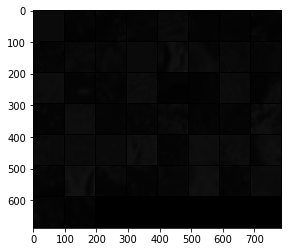

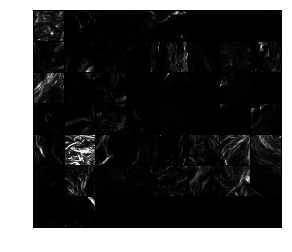

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


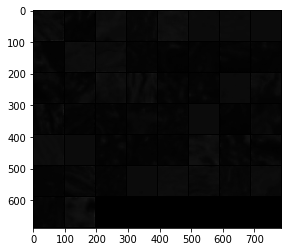

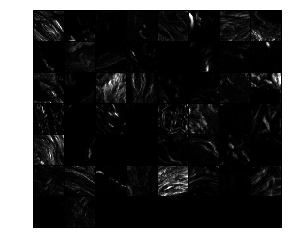

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


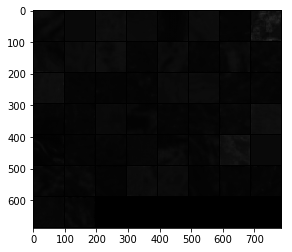

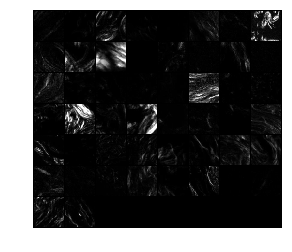

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


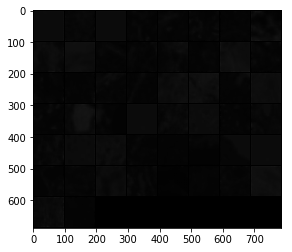

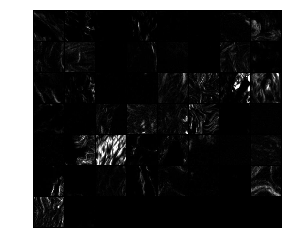

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


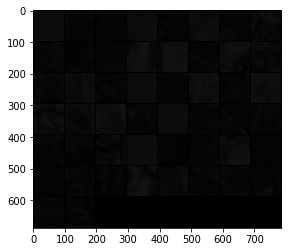

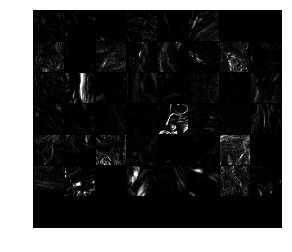

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


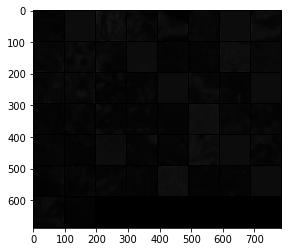

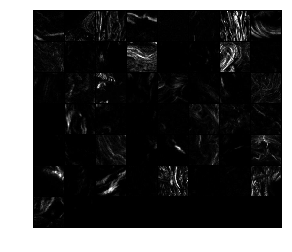

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


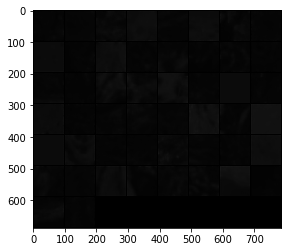

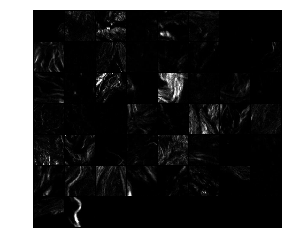

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


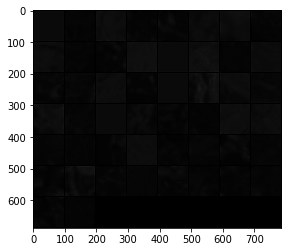

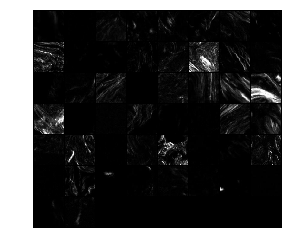

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


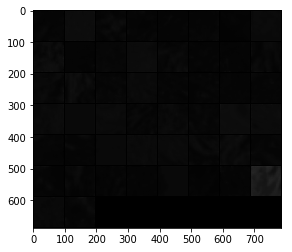

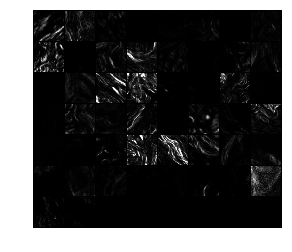

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


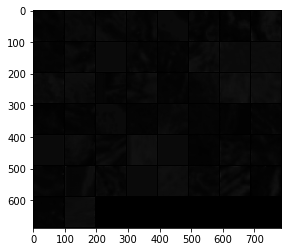

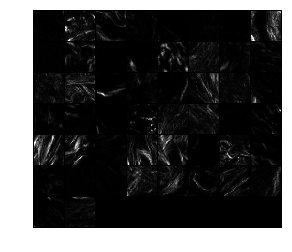

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


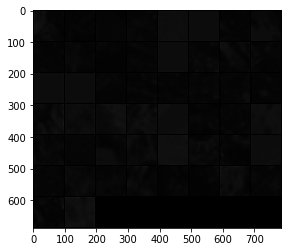

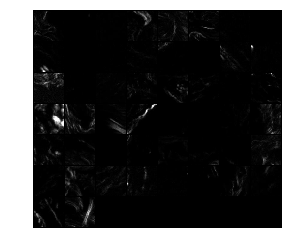

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


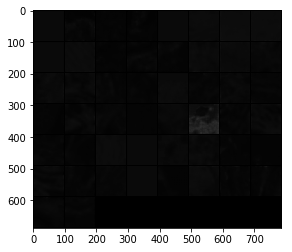

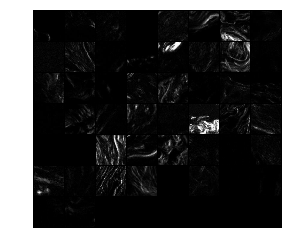

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


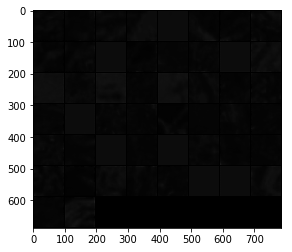

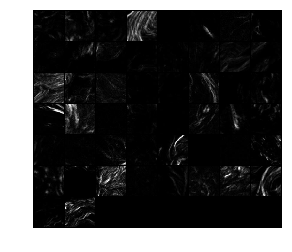

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


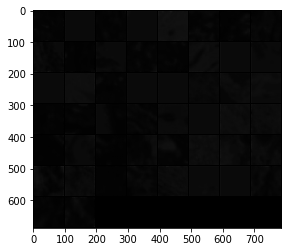

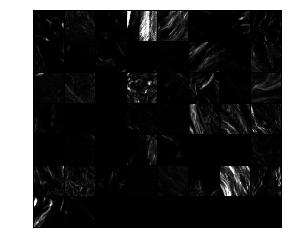

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


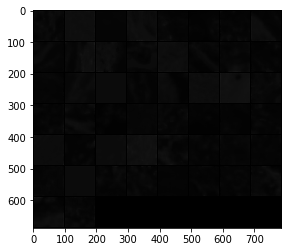

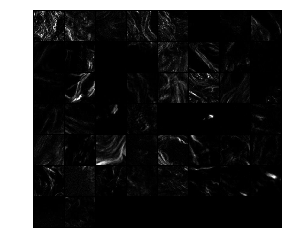

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


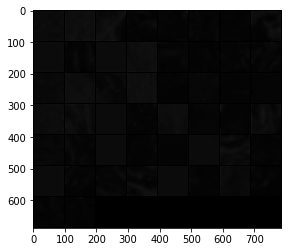

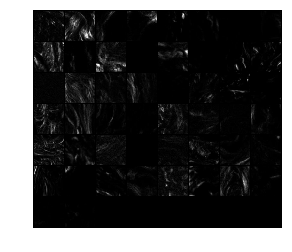

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


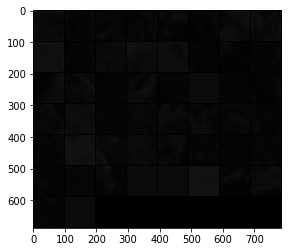

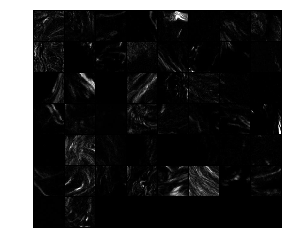

===> Avg. PSNR: nan dB


In [14]:
test()

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.030958833172917366 lossSSIM: 0.16248154640197754
===> Epoch[1](0/16220): Loss: 0.0638
lossMSE: 0.020479219034314156 lossSSIM: 0.18249160051345825
===> Epoch[1](50/16220): Loss: 0.0610
lossMSE: 0.030857721343636513 lossSSIM: 0.17062854766845703
===> Epoch[1](100/16220): Loss: 0.0658
lossMSE: 0.03577927127480507 lossSSIM: 0.14344239234924316
===> Epoch[1](150/16220): Loss: 0.0627
lossMSE: 0.031723566353321075 lossSSIM: 0.22476035356521606
===> Epoch[1](200/16220): Loss: 0.0800
lossMSE: 0.028640618547797203 lossSSIM: 0.19763976335525513
===> Epoch[1](250/16220): Loss: 0.0709
lossMSE: 0.016669075936079025 lossSSIM: 0.14080095291137695
===> Epoch[1](300/16220): Loss: 0.0477
lossMSE: 0.01385572925209999 lossSSIM: 0.13726389408111572
===> Epoch[1](350/16220): Loss: 0.0447
lossMSE: 0.026466550305485725 lossSSIM: 0.16083091497421265
===> Epoch[1](400/16220): Loss: 0.0601
lossMSE: 0.025972310453653336 lossSSIM: 0.15242815017700195
===> Epoch[1](450/16220): Loss: 0.0576
lossMSE: 0.0277

lossMSE: 0.027905061841011047 lossSSIM: 0.1562645435333252
===> Epoch[1](4150/16220): Loss: 0.0600
lossMSE: 0.024874404072761536 lossSSIM: 0.18550854921340942
===> Epoch[1](4200/16220): Loss: 0.0650
lossMSE: 0.029877284541726112 lossSSIM: 0.21828031539916992
===> Epoch[1](4250/16220): Loss: 0.0770
lossMSE: 0.05040832608938217 lossSSIM: 0.17396903038024902
===> Epoch[1](4300/16220): Loss: 0.0813
lossMSE: 0.028562841936945915 lossSSIM: 0.14741617441177368
===> Epoch[1](4350/16220): Loss: 0.0583
lossMSE: 0.04617471620440483 lossSSIM: 0.18773311376571655
===> Epoch[1](4400/16220): Loss: 0.0816
lossMSE: 0.02995769865810871 lossSSIM: 0.18866783380508423
===> Epoch[1](4450/16220): Loss: 0.0696
lossMSE: 0.017212703824043274 lossSSIM: 0.14997732639312744
===> Epoch[1](4500/16220): Loss: 0.0504
lossMSE: 0.016581453382968903 lossSSIM: 0.16177982091903687
===> Epoch[1](4550/16220): Loss: 0.0529
lossMSE: 0.022877376526594162 lossSSIM: 0.1795688271522522
===> Epoch[1](4600/16220): Loss: 0.0621
lossM

lossMSE: 0.017209021374583244 lossSSIM: 0.15261274576187134
===> Epoch[1](8300/16220): Loss: 0.0511
lossMSE: 0.025818508118391037 lossSSIM: 0.1938410997390747
===> Epoch[1](8350/16220): Loss: 0.0678
lossMSE: 0.01797797717154026 lossSSIM: 0.17330598831176758
===> Epoch[1](8400/16220): Loss: 0.0568
lossMSE: 0.05307181552052498 lossSSIM: 0.21357035636901855
===> Epoch[1](8450/16220): Loss: 0.0932
lossMSE: 0.023174189031124115 lossSSIM: 0.11886966228485107
===> Epoch[1](8500/16220): Loss: 0.0471
lossMSE: 0.020435316488146782 lossSSIM: 0.1384371519088745
===> Epoch[1](8550/16220): Loss: 0.0499
lossMSE: 0.018471283838152885 lossSSIM: 0.17034155130386353
===> Epoch[1](8600/16220): Loss: 0.0564
lossMSE: 0.030286485329270363 lossSSIM: 0.1539706587791443
===> Epoch[1](8650/16220): Loss: 0.0612
lossMSE: 0.01975310407578945 lossSSIM: 0.1866859793663025
===> Epoch[1](8700/16220): Loss: 0.0615
lossMSE: 0.0265383068472147 lossSSIM: 0.1781434416770935
===> Epoch[1](8750/16220): Loss: 0.0644
lossMSE: 0

lossMSE: 0.020766636356711388 lossSSIM: 0.15009945631027222
===> Epoch[1](12450/16220): Loss: 0.0531
lossMSE: 0.02815856970846653 lossSSIM: 0.13839846849441528
===> Epoch[1](12500/16220): Loss: 0.0557
lossMSE: 0.02332417294383049 lossSSIM: 0.17083507776260376
===> Epoch[1](12550/16220): Loss: 0.0602
lossMSE: 0.023250184953212738 lossSSIM: 0.1872483491897583
===> Epoch[1](12600/16220): Loss: 0.0642
lossMSE: 0.011208887211978436 lossSSIM: 0.12833362817764282
===> Epoch[1](12650/16220): Loss: 0.0405
lossMSE: 0.024686647579073906 lossSSIM: 0.17564070224761963
===> Epoch[1](12700/16220): Loss: 0.0624
lossMSE: 0.02278626151382923 lossSSIM: 0.1571677327156067
===> Epoch[1](12750/16220): Loss: 0.0564
lossMSE: 0.010453300550580025 lossSSIM: 0.132210373878479
===> Epoch[1](12800/16220): Loss: 0.0409
lossMSE: 0.017559608444571495 lossSSIM: 0.15155166387557983
===> Epoch[1](12850/16220): Loss: 0.0511
lossMSE: 0.03239183500409126 lossSSIM: 0.1631765365600586
===> Epoch[1](12900/16220): Loss: 0.0651

lossMSE: 0.035775527358055115 lossSSIM: 0.19684404134750366
===> Epoch[2](300/16220): Loss: 0.0760
lossMSE: 0.01419746782630682 lossSSIM: 0.14948105812072754
===> Epoch[2](350/16220): Loss: 0.0480
lossMSE: 0.013495254330337048 lossSSIM: 0.15763789415359497
===> Epoch[2](400/16220): Loss: 0.0495
lossMSE: 0.032286692410707474 lossSSIM: 0.18761426210403442
===> Epoch[2](450/16220): Loss: 0.0711
lossMSE: 0.01944860629737377 lossSSIM: 0.15605765581130981
===> Epoch[2](500/16220): Loss: 0.0536
lossMSE: 0.02513676881790161 lossSSIM: 0.18486934900283813
===> Epoch[2](550/16220): Loss: 0.0651
lossMSE: 0.034587208181619644 lossSSIM: 0.15574777126312256
===> Epoch[2](600/16220): Loss: 0.0649
lossMSE: 0.011926260776817799 lossSSIM: 0.1274285912513733
===> Epoch[2](650/16220): Loss: 0.0408
lossMSE: 0.02801383100450039 lossSSIM: 0.1460513472557068
===> Epoch[2](700/16220): Loss: 0.0575
lossMSE: 0.019749850034713745 lossSSIM: 0.1685435175895691
===> Epoch[2](750/16220): Loss: 0.0569
lossMSE: 0.033113

lossMSE: 0.01429679337888956 lossSSIM: 0.15591275691986084
===> Epoch[2](4450/16220): Loss: 0.0497
lossMSE: 0.016150005161762238 lossSSIM: 0.16115134954452515
===> Epoch[2](4500/16220): Loss: 0.0524
lossMSE: 0.012523112818598747 lossSSIM: 0.13007503747940063
===> Epoch[2](4550/16220): Loss: 0.0419
lossMSE: 0.020362578332424164 lossSSIM: 0.13941234350204468
===> Epoch[2](4600/16220): Loss: 0.0501
lossMSE: 0.016071777790784836 lossSSIM: 0.14501631259918213
===> Epoch[2](4650/16220): Loss: 0.0483
lossMSE: 0.02414519339799881 lossSSIM: 0.14552831649780273
===> Epoch[2](4700/16220): Loss: 0.0545
lossMSE: 0.017267880961298943 lossSSIM: 0.15968835353851318
===> Epoch[2](4750/16220): Loss: 0.0529
lossMSE: 0.021223848685622215 lossSSIM: 0.18208354711532593
===> Epoch[2](4800/16220): Loss: 0.0614
lossMSE: 0.0561395063996315 lossSSIM: 0.1982061266899109
===> Epoch[2](4850/16220): Loss: 0.0917
lossMSE: 0.030765047296881676 lossSSIM: 0.2101781964302063
===> Epoch[2](4900/16220): Loss: 0.0756
lossMS

lossMSE: 0.04065580666065216 lossSSIM: 0.17562949657440186
===> Epoch[2](8600/16220): Loss: 0.0744
lossMSE: 0.02402028813958168 lossSSIM: 0.1744118332862854
===> Epoch[2](8650/16220): Loss: 0.0616
lossMSE: 0.022948680445551872 lossSSIM: 0.16679370403289795
===> Epoch[2](8700/16220): Loss: 0.0589
lossMSE: 0.02845962718129158 lossSSIM: 0.17217475175857544
===> Epoch[2](8750/16220): Loss: 0.0644
lossMSE: 0.028785105794668198 lossSSIM: 0.1534411907196045
===> Epoch[2](8800/16220): Loss: 0.0599
lossMSE: 0.02526598423719406 lossSSIM: 0.1740090250968933
===> Epoch[2](8850/16220): Loss: 0.0625
lossMSE: 0.019654637202620506 lossSSIM: 0.15073180198669434
===> Epoch[2](8900/16220): Loss: 0.0524
lossMSE: 0.025002751499414444 lossSSIM: 0.18508076667785645
===> Epoch[2](8950/16220): Loss: 0.0650
lossMSE: 0.021214475855231285 lossSSIM: 0.15632843971252441
===> Epoch[2](9000/16220): Loss: 0.0550
lossMSE: 0.03992890566587448 lossSSIM: 0.18324506282806396
===> Epoch[2](9050/16220): Loss: 0.0758
lossMSE:

lossMSE: 0.016768742352724075 lossSSIM: 0.14071166515350342
===> Epoch[2](12750/16220): Loss: 0.0478
lossMSE: 0.025726009160280228 lossSSIM: 0.16289329528808594
===> Epoch[2](12800/16220): Loss: 0.0600
lossMSE: 0.03153138607740402 lossSSIM: 0.17039769887924194
===> Epoch[2](12850/16220): Loss: 0.0662
lossMSE: 0.021318048238754272 lossSSIM: 0.14655828475952148
===> Epoch[2](12900/16220): Loss: 0.0526
lossMSE: 0.024796711280941963 lossSSIM: 0.17289596796035767
===> Epoch[2](12950/16220): Loss: 0.0618
lossMSE: 0.035673387348651886 lossSSIM: 0.15942931175231934
===> Epoch[2](13000/16220): Loss: 0.0666
lossMSE: 0.017200302332639694 lossSSIM: 0.1587008833885193
===> Epoch[2](13050/16220): Loss: 0.0526
lossMSE: 0.028080817312002182 lossSSIM: 0.1697731614112854
===> Epoch[2](13100/16220): Loss: 0.0635
lossMSE: 0.034849297255277634 lossSSIM: 0.17328590154647827
===> Epoch[2](13150/16220): Loss: 0.0695
lossMSE: 0.021428409963846207 lossSSIM: 0.15760409832000732
===> Epoch[2](13200/16220): Loss: 

lossMSE: 0.01466248370707035 lossSSIM: 0.11842143535614014
===> Epoch[3](600/16220): Loss: 0.0406
lossMSE: 0.01297695655375719 lossSSIM: 0.11675363779067993
===> Epoch[3](650/16220): Loss: 0.0389
lossMSE: 0.03142706677317619 lossSSIM: 0.19864130020141602
===> Epoch[3](700/16220): Loss: 0.0732
lossMSE: 0.04837685450911522 lossSSIM: 0.21013402938842773
===> Epoch[3](750/16220): Loss: 0.0888
lossMSE: 0.04560783505439758 lossSSIM: 0.19800347089767456
===> Epoch[3](800/16220): Loss: 0.0837
lossMSE: 0.03926168382167816 lossSSIM: 0.21121448278427124
===> Epoch[3](850/16220): Loss: 0.0822
lossMSE: 0.015732452273368835 lossSSIM: 0.14164453744888306
===> Epoch[3](900/16220): Loss: 0.0472
lossMSE: 0.016951002180576324 lossSSIM: 0.1648789644241333
===> Epoch[3](950/16220): Loss: 0.0539
lossMSE: 0.019590839743614197 lossSSIM: 0.19279879331588745
===> Epoch[3](1000/16220): Loss: 0.0629
lossMSE: 0.02179163694381714 lossSSIM: 0.15293318033218384
===> Epoch[3](1050/16220): Loss: 0.0546
lossMSE: 0.02904

lossMSE: 0.0310119166970253 lossSSIM: 0.21700090169906616
===> Epoch[3](4750/16220): Loss: 0.0775
lossMSE: 0.027879711240530014 lossSSIM: 0.1414330005645752
===> Epoch[3](4800/16220): Loss: 0.0563
lossMSE: 0.019316092133522034 lossSSIM: 0.14934802055358887
===> Epoch[3](4850/16220): Loss: 0.0518
lossMSE: 0.023724958300590515 lossSSIM: 0.15211701393127441
===> Epoch[3](4900/16220): Loss: 0.0558
lossMSE: 0.024044033139944077 lossSSIM: 0.16760581731796265
===> Epoch[3](4950/16220): Loss: 0.0599
lossMSE: 0.02252069301903248 lossSSIM: 0.15991699695587158
===> Epoch[3](5000/16220): Loss: 0.0569
lossMSE: 0.03797704726457596 lossSSIM: 0.20805805921554565
===> Epoch[3](5050/16220): Loss: 0.0805
lossMSE: 0.01170776691287756 lossSSIM: 0.1335763931274414
===> Epoch[3](5100/16220): Loss: 0.0422
lossMSE: 0.02375682070851326 lossSSIM: 0.17946720123291016
===> Epoch[3](5150/16220): Loss: 0.0627
lossMSE: 0.028042491525411606 lossSSIM: 0.20171856880187988
===> Epoch[3](5200/16220): Loss: 0.0715
lossMSE:

lossMSE: 0.03606902062892914 lossSSIM: 0.18632739782333374
===> Epoch[3](8900/16220): Loss: 0.0736
lossMSE: 0.019273869693279266 lossSSIM: 0.1324518322944641
===> Epoch[3](8950/16220): Loss: 0.0476
lossMSE: 0.03367498889565468 lossSSIM: 0.1842578649520874
===> Epoch[3](9000/16220): Loss: 0.0713
lossMSE: 0.02674494870007038 lossSSIM: 0.17373156547546387
===> Epoch[3](9050/16220): Loss: 0.0635
lossMSE: 0.05018800124526024 lossSSIM: 0.24138176441192627
===> Epoch[3](9100/16220): Loss: 0.0980
lossMSE: 0.016375282779335976 lossSSIM: 0.12759995460510254
===> Epoch[3](9150/16220): Loss: 0.0442
lossMSE: 0.019235916435718536 lossSSIM: 0.15717953443527222
===> Epoch[3](9200/16220): Loss: 0.0537
lossMSE: 0.03408889099955559 lossSSIM: 0.20209842920303345
===> Epoch[3](9250/16220): Loss: 0.0761
lossMSE: 0.026071446016430855 lossSSIM: 0.1624179482460022
===> Epoch[3](9300/16220): Loss: 0.0602
lossMSE: 0.02352876588702202 lossSSIM: 0.15164655447006226
===> Epoch[3](9350/16220): Loss: 0.0556
lossMSE: 

lossMSE: 0.021261906251311302 lossSSIM: 0.14270401000976562
===> Epoch[3](13050/16220): Loss: 0.0516
lossMSE: 0.024936188012361526 lossSSIM: 0.14110684394836426
===> Epoch[3](13100/16220): Loss: 0.0540
lossMSE: 0.02398046851158142 lossSSIM: 0.1692032814025879
===> Epoch[3](13150/16220): Loss: 0.0603
lossMSE: 0.0303807370364666 lossSSIM: 0.20185953378677368
===> Epoch[3](13200/16220): Loss: 0.0733
lossMSE: 0.01345618162304163 lossSSIM: 0.15162992477416992
===> Epoch[3](13250/16220): Loss: 0.0480
lossMSE: 0.03551565483212471 lossSSIM: 0.21603482961654663
===> Epoch[3](13300/16220): Loss: 0.0806
lossMSE: 0.029663901776075363 lossSSIM: 0.1876509189605713
===> Epoch[3](13350/16220): Loss: 0.0692
lossMSE: 0.04356987029314041 lossSSIM: 0.1616491675376892
===> Epoch[3](13400/16220): Loss: 0.0731
lossMSE: 0.013166175223886967 lossSSIM: 0.14704376459121704
===> Epoch[3](13450/16220): Loss: 0.0466
lossMSE: 0.02569548971951008 lossSSIM: 0.1761360764503479
===> Epoch[3](13500/16220): Loss: 0.0633
l

lossMSE: 0.016306987032294273 lossSSIM: 0.17019140720367432
===> Epoch[4](900/16220): Loss: 0.0548
lossMSE: 0.025683598592877388 lossSSIM: 0.1594393253326416
===> Epoch[4](950/16220): Loss: 0.0591
lossMSE: 0.015384091064333916 lossSSIM: 0.17491787672042847
===> Epoch[4](1000/16220): Loss: 0.0553
lossMSE: 0.035539377480745316 lossSSIM: 0.19274336099624634
===> Epoch[4](1050/16220): Loss: 0.0748
lossMSE: 0.026851721107959747 lossSSIM: 0.1715024709701538
===> Epoch[4](1100/16220): Loss: 0.0630
lossMSE: 0.011001002043485641 lossSSIM: 0.13203895092010498
===> Epoch[4](1150/16220): Loss: 0.0413
lossMSE: 0.014876144006848335 lossSSIM: 0.13081353902816772
===> Epoch[4](1200/16220): Loss: 0.0439
lossMSE: 0.027792571112513542 lossSSIM: 0.1648111343383789
===> Epoch[4](1250/16220): Loss: 0.0620
lossMSE: 0.01051825936883688 lossSSIM: 0.12656736373901367
===> Epoch[4](1300/16220): Loss: 0.0395
lossMSE: 0.017819052562117577 lossSSIM: 0.14976918697357178
===> Epoch[4](1350/16220): Loss: 0.0508
lossMS

lossMSE: 0.012892167083919048 lossSSIM: 0.16332566738128662
===> Epoch[4](5050/16220): Loss: 0.0505
lossMSE: 0.022023633122444153 lossSSIM: 0.14290368556976318
===> Epoch[4](5100/16220): Loss: 0.0522
lossMSE: 0.02149866335093975 lossSSIM: 0.18924009799957275
===> Epoch[4](5150/16220): Loss: 0.0634
lossMSE: 0.027209002524614334 lossSSIM: 0.16844773292541504
===> Epoch[4](5200/16220): Loss: 0.0625
lossMSE: 0.01750197447836399 lossSSIM: 0.16472840309143066
===> Epoch[4](5250/16220): Loss: 0.0543
lossMSE: 0.016683125868439674 lossSSIM: 0.1461489200592041
===> Epoch[4](5300/16220): Loss: 0.0490
lossMSE: 0.02966182865202427 lossSSIM: 0.1940244436264038
===> Epoch[4](5350/16220): Loss: 0.0708
lossMSE: 0.020129529759287834 lossSSIM: 0.16664481163024902
===> Epoch[4](5400/16220): Loss: 0.0568
lossMSE: 0.019754160195589066 lossSSIM: 0.13789057731628418
===> Epoch[4](5450/16220): Loss: 0.0493
lossMSE: 0.019768001511693 lossSSIM: 0.17452305555343628
===> Epoch[4](5500/16220): Loss: 0.0585
lossMSE:

lossMSE: 0.01695137284696102 lossSSIM: 0.14425987005233765
===> Epoch[4](9200/16220): Loss: 0.0488
lossMSE: 0.02008403278887272 lossSSIM: 0.1589227318763733
===> Epoch[4](9250/16220): Loss: 0.0548
lossMSE: 0.01865427941083908 lossSSIM: 0.1502612829208374
===> Epoch[4](9300/16220): Loss: 0.0516
lossMSE: 0.03058842569589615 lossSSIM: 0.16401195526123047
===> Epoch[4](9350/16220): Loss: 0.0639
lossMSE: 0.028961464762687683 lossSSIM: 0.1970098614692688
===> Epoch[4](9400/16220): Loss: 0.0710
lossMSE: 0.02376682311296463 lossSSIM: 0.15173029899597168
===> Epoch[4](9450/16220): Loss: 0.0558
lossMSE: 0.027693631127476692 lossSSIM: 0.16731137037277222
===> Epoch[4](9500/16220): Loss: 0.0626
lossMSE: 0.02796919457614422 lossSSIM: 0.18940067291259766
===> Epoch[4](9550/16220): Loss: 0.0683
lossMSE: 0.03551927208900452 lossSSIM: 0.18910455703735352
===> Epoch[4](9600/16220): Loss: 0.0739
lossMSE: 0.024962373077869415 lossSSIM: 0.19019842147827148
===> Epoch[4](9650/16220): Loss: 0.0663
lossMSE: 0

lossMSE: 0.019325245171785355 lossSSIM: 0.15595877170562744
===> Epoch[4](13300/16220): Loss: 0.0535
lossMSE: 0.031083226203918457 lossSSIM: 0.14668619632720947
===> Epoch[4](13350/16220): Loss: 0.0600
lossMSE: 0.028150616213679314 lossSSIM: 0.1923748254776001
===> Epoch[4](13400/16220): Loss: 0.0692
lossMSE: 0.0068015228025615215 lossSSIM: 0.11872076988220215
===> Epoch[4](13450/16220): Loss: 0.0348
lossMSE: 0.026026442646980286 lossSSIM: 0.18066370487213135
===> Epoch[4](13500/16220): Loss: 0.0647
lossMSE: 0.01757683791220188 lossSSIM: 0.15525656938552856
===> Epoch[4](13550/16220): Loss: 0.0520
lossMSE: 0.010500865057110786 lossSSIM: 0.1418883204460144
===> Epoch[4](13600/16220): Loss: 0.0433
lossMSE: 0.027742953971028328 lossSSIM: 0.20275098085403442
===> Epoch[4](13650/16220): Loss: 0.0715
lossMSE: 0.014171222224831581 lossSSIM: 0.14467531442642212
===> Epoch[4](13700/16220): Loss: 0.0468
lossMSE: 0.027444303035736084 lossSSIM: 0.16419905424118042
===> Epoch[4](13750/16220): Loss:

KeyboardInterrupt: 